### <center> Resolution of Max-Cut using a logarithmic encoding and Pauli decomposition. </center>

<center> Author : Leder Aguirre </center>
<center> Date : 2023 </center>

### Table of contents

1. [Introduction](#introduction)
    1. [Problem](#problem)
    2. [Algorithm](#algorithm)
    3. [Grouping the Pauli strings](#pauli_group)
2. [Importations](#importations)
3. [Toy example](#toy_example)
    1. [Abelian Grouping](#abelian_grouping_1)
    2. [Dense grouping](#dense_grouping_1)
4. [Performance tests on random instances](#random_instances)
    1. [Abelian Grouping](#abelian_grouping_2)
    2. [Dense grouping](#dense_grouping_2)
5. [Bibliography](#bibliography)
$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}
\renewcommand{\bra}[1]{\left\langle{#1}\right|}
\newcommand{\ceil}[1]{\left\lceil{ #1 }\right\rceil}
\newcommand{\floor}[1]{\left\lfloor{ #1 }\right\rfloor}
$

#### Problem

For an graph $G=(V,E)$ with edge weights $c_e$, the Max(imum) Cut problem is to find a cut $S \subset V$ such that the weight of edges accross $(S,\bar{S})$ is maximized. It can be formulated as the Quadratic Unconstrained Optimization Problem (QUBO):

Let $y_i$ be the decision variable, equal to 1 if the node $i$ belongs to $S$, -1 otherwise. The optimization problem is:

\begin{align}
\text{max} & \quad & \sum_{(i,j) \in E} w_{i,j} \left(\frac{1 - y_iy_j}{2} \right)\\
\text{s.t.} & \quad & y_i \in \{-1,1\} \quad \forall i \in V
\end{align}

#### Algorithm

The quantum algorithm based on logarithmic encoding (QABLE) is a variational algorithm that uses an unitary $\hat{U}(\theta)$ characterized by the parameters $\theta \in \mathbb{R}^{N}$ to prepare a quantum state $\ket{\psi_{\bar{y}}}$ encoding a *particular solution* to the combinatorial optimization problem (COP), where $N$ is the number of variables. This state is prepared according to the equation below:

\begin{align}
    \ket{\psi_{y}} &\coloneqq \frac{1}{\sqrt{N}} \sum_{k=0}^{N} y_k \ket{k}_{\log(\ceil{N})} = \frac{1}{\sqrt{N}} \sum_{k=0}^{N} e^{i\pi x_k } \ket{k}_{\log(\ceil{N})}\\
    &= \frac{1}{\sqrt{N}} \sum_{k=0}^{N} e^{i\pi R_f(\theta_k) } \ket{k}_{\log(\ceil{N})} = \hat{U}(\theta) \sum_{k=0}^{N} \ket{k}_{\log(\ceil{N})} \nonumber\\
    &= \hat{U}(\theta) \ket{+ \dots +}_{\log(\ceil{N})} = \hat{U}(\theta) \hat{\mathcal{H}}^{\otimes \log(\ceil{N})} \ket{0}_{\log(\ceil{N})}
\end{align}

where the $x_k = R_f(\theta_k), \theta_k \in \mathbb{R}$ can be interpreted as a projection from a (possibly unfeasible) solution to the set of feasible solutions ($x_k \in \{0,1\}$). The function $R_f$ is designed to be a smooth version (differentiable) of the step function.

The quantum algorithm based on logarithmic encoding (QABLE) is described by the following process:
	
1. Initialize $\theta$ to suitable real values.
2. Calculate the coefficients $c'_k$ of the QUBO matrix $Q$ in the Pauli base.
3. For each element $J_k$ of the real $\log(\ceil{N})$-Pauli base:
    1. Compute the expectation $\bra{\psi\left(\theta\right)} \hat{H}_P \ket{\psi\left(\theta\right)}$ via a sampling procedure.
    2. Find a better set of parameters $\theta$ using a classical optimization algorithm.
    3. Set the current parameters $\theta$ equal to the new parameters $\theta_{new}$.

*Important remarks*:
- The operator $\hat{H}_p$ does not act as a Hamiltonian in this approach because we are not really evolving a quantum state.
- This approach only uses the quantum computer to calculate the expected value faster by the logarithmic encoding and the Pauli decomposition and grouping.

### 2. Importations <a name="importations"></a>

In [1]:
# Imports non Qiskit
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random

# Imports Qiskit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute,IBMQ
from qiskit.visualization import plot_histogram

from qiskit.circuit.library import Diagonal
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.opflow import CircuitStateFn, PauliSumOp
from qiskit.opflow import CircuitSampler, StateFn, AerPauliExpectation, PauliExpectation

from qiskit import Aer
from qiskit.utils import QuantumInstance

# Imports customs
sys.path.append('../code')
#from c_utilities import readGraph, correct_dim
from expectation_functions import R_map, Rf_map, Rfs_map
from expectation_functions import getExpectedValue, parameterizedCircuit, getExpectation
from graph_functions import get_laplacian_matrix
from RG_generator import generate_random_graphs

### 3. Toy example <a name="toy_example"></a>

In this section, we will work with a simple instance: a graph with 4 nodes and 3 edges. We plot the graph below so it is clear that the optimal value is 3 and the solution is given by the partition $C = \{\{0,2\}, \{1,3\} \}$.

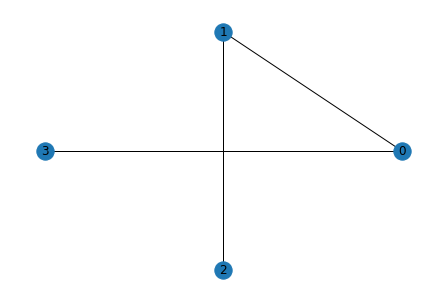

In [5]:
## read the graph
G = nx.readwrite.edgelist.read_weighted_edgelist("../created_data/toy_graph_4.col")    # toy example: 4 nodes, 3 edges
N = G.number_of_nodes()
log_N = int(np.ceil(np.log2(N))) # smaller k such that k >= log2(N)
N_ = 2**log_N                   # corrected number of nodes so that N = 2^k for some k

## draw the graph
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True)
#nx.draw_networkx_edge_labels(G, pos)
plt.show()

#### 3.2 Ansatz
##### 3.2.1 Initializing qubits

Before applying the unitary transformation $U(\theta)$, we wish to bring the qubits into the equal superposition state by applying a Hadamard gate on each qubit.

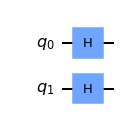

In [9]:
qc_init = QuantumCircuit(log_N)
for i in range(log_N):
    qc_init.h(i)

qc_init.draw()

##### 3.2.2 Constructing the unitary transformation $U(\theta)$

For a fixed $\theta \in \mathbb{R}^{|V|}$, the unitary transformation $U(\theta) = \text{diag}(( e^{i\pi R_f(\theta_k) })_k)$ only have entries in $\{-1,0,1\}$. A diagonal operator with entries in $\{-1,1\}$ ca be implemented in terms of uniformly controlled rotation [3].

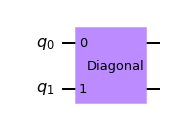

In [8]:
## visual verification of psi

# parameters
theta = [random.randint(0,3)/4 for i in range(2**log_N)]    # divided by 4 to get an infeasible initial solution and by 2 to get a feasible one
R_f = Rf_map(theta)
U_diag = np.exp(complex(0,np.pi)*R_f)

# quantum circuit
qc_u = Diagonal(U_diag)

#qc.decompose(reps=3).draw(output="mpl")
qc_u.draw()

##### 3.2.4 Assemble the quantum ciruit

Now we have got all building blocks we need. It's time to assemble the above parts together to make a complete parametrized quantum circuit.

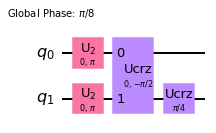

In [12]:
qc_qableM = QuantumCircuit(log_N)
qc_qableM.append(qc_init, range(log_N))
qc_qableM.append(qc_u, range(log_N))

qc_qableM.decompose().decompose().draw()    # decompose only once to see the two blocks

#### 3.3 Solve the instance
##### 3.3.1 Decompose the QUBO matrix in the Pauli base

To calculate the expectation value, we write the QUBO matrix $Q = -\frac{L}{4}$ in the Pauli base (L is the Laplacian matrix).

\begin{align}
    Q = \sum_{k=0}^{|V|^2 - 1} c_k J_k
\end{align}

where $J_k$ is a Pauli string of size n = $\ceil{\log(|V|)}$ (the tensor product of $n$ Pauli matrices) and $c_k = \frac{1}{2^n} Tr(J_k Q) \forall k$. By linearity of the expectation value, we have:

\begin{align}
    \bra{\psi} \hat{Q} \ket{\psi} = \sum_{k=0}^{|V|^2 - 1} c_k \bra{\psi} \hat{J}_k \ket{\psi}
\end{align}

This would require $|V|^2$ independent quantum circuits, but it is possible to get the same result with only $\mathcal{O}(|V|^{\log(3)})$. This reduction comes from the fact that we can use the same circuit to calculate the expectation of two Pauli strings $J_k,J_k'$ that commute. It is possible to compute fastly a partition consisting in $\mathcal{O}(|V|^{\log(3)})$ sets of pairwise commuting Pauli strings [4].

In [15]:
## verification of the Hamiltonien decomposition in Pauli strings

Q = (-2**(log_N-2))*get_laplacian_matrix(G)             # Observable
pauli_op = SparsePauliOp.from_operator(Q)
op = PauliSumOp(pauli_op)
pauli_op.to_list()

NameError: name 'Q' is not defined

##### 3.3.2 Execute the ansatz

Let us execute the circuit with a Qiskit qasm-simulator which runs locally on your pc or laptop. To use a classical optimizer, we need to provide a Python function that for a fixed $(\beta, \gamma)$, gives us the expectation value. In this implementation we will use the second architecture and we define $\theta = (\beta,\gamma)$. For $T > 1$, we only have to define $\theta \in \mathbb{R}^{2T}$, where the first T entries are the values of $\beta \in \mathbb{R}^T$, while the other $T$ entries are the entries for $\gamma \in \mathbb{R}^T$.

### 5. Bibliography <a name="bibliography"></a>

1. Marko J Rancic. “Noisy intermediate-scale quantum computing algorithm for
solving an n-vertex MaxCut problem with log (n) qubits”. In: Physical Review
Research 5.1 (2023), p. L012021. <a name="marko_2023"></a>
2. Yagnik Chatterjee, Eric Bourreau, and Marko J Rancic. “Solving various NPHard
problems using exponentially fewer qubits on a Quantum Computer”.
In: arXiv preprint arXiv:2301.06978 (2023). <a name="chatterjee_2023"></a>
3. Shende, V. V., Bullock, S. S., & Markov, I. L. (2005, January). Synthesis of quantum logic circuits. In Proceedings of the 2005 Asia and South Pacific Design Automation Conference (pp. 272-275).
4. Hamamura, I., & Imamichi, T. (2020). Efficient evaluation of quantum observables using entangled measurements. npj Quantum Information, 6(1), 56.